In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Data Exploration

In [6]:
url='https://en.wikipedia.org/wiki/List_of_municipalities_in_Tennessee'
data = requests.get(url).text
print('Data downloaded!')

Data downloaded!


In [8]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(data, 'html5lib')

In [9]:
tables = soup.find_all('table')
len(tables)


for index, table in enumerate(tables):
    if("Population" in str(table)):
        table_index=index
        
print(tables[table_index].prettify())

<table class="wikitable sortable">
 <tbody>
  <tr>
   <th style="width:10em; background-color:#cee0f2;">
    <b>
     Place Name
    </b>
   </th>
   <th style="width:10em; background-color:#cee0f2;">
    <b>
     <a href="/wiki/County_(United_States)" title="County (United States)">
      County(ies)
     </a>
    </b>
    <span style="font-weight:normal;">
     <sup class="reference" id="ref_primary">
      <a href="#endnote_primary">
       [B]
      </a>
     </sup>
    </span>
   </th>
   <th style="background-color:#cee0f2;">
    <b>
     Population
    </b>
    <br/>
    (2010 Census)
    <span style="font-weight:normal;">
     <sup class="reference" id="cite_ref-wwwcensusgov_5-0">
      <a href="#cite_note-wwwcensusgov-5">
       [5]
      </a>
     </sup>
    </span>
   </th>
   <th style="background-color:#cee0f2;">
    <b>
     Area
    </b>
    <br/>
    (as of 2010)
    <span style="font-weight:normal;">
     <sup class="reference" id="cite_ref-wwwcensusgov_5-1">
      <a 

In [26]:
tn = pd.DataFrame(columns=['City', 'County','Population','Area (sqmi)','Region'])

for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if(col!=[]):
        city = col[0].text.rstrip('\n')
        county = col[1].text.replace("$", "").replace(",", "").rstrip('\n')
        population = col[2].text.replace(",", "").rstrip('\n')
        area = col[3].text.split('sq',1)[0].rstrip('\n').strip()
        region = col[6].text.rstrip('\n')
        tn = tn.append({'City': city, 'County': county, 'Population': population, 'Area (sqmi)':area, 'Region':region}, ignore_index=True)
        
tn.head()

,City,County,Population,Area (sqmi),Region
0,Adams,Robertson County,633,2.68,Middle
1,Adamsville,McNairy CountyHardin County,2207,6.91,West
2,Alamo,Crockett County,2461,2.2,West
3,Alcoa,Blount County,8449,15.66,East
4,Alexandria,DeKalb County,966,2.02,Middle


In [29]:
tn['Population'] = pd.to_numeric(tn['Population'])
tn['Area (sqmi)'] = pd.to_numeric(tn['Area (sqmi)'])
tn['Density'] = tn['Population']/tn['Area (sqmi)'] #add in population density data

tn.head()

,City,County,Population,Area (sqmi),Region,Density
0,Adams,Robertson County,633,2.68,Middle,236.194030
1,Adamsville,McNairy CountyHardin County,2207,6.91,West,319.392185
2,Alamo,Crockett County,2461,2.20,West,1118.636364
3,Alcoa,Blount County,8449,15.66,East,539.527458
4,Alexandria,DeKalb County,966,2.02,Middle,478.217822


In [34]:
#drop the rows with missing values in any columns
tn.replace('NaN', np.nan, inplace=True)
tn = tn.dropna()
print(len(tn))
tn.head()

346


,City,County,Population,Area (sqmi),Region,Density
0,Adams,Robertson County,633,2.68,Middle,236.194030
1,Adamsville,McNairy CountyHardin County,2207,6.91,West,319.392185
2,Alamo,Crockett County,2461,2.20,West,1118.636364
3,Alcoa,Blount County,8449,15.66,East,539.527458
4,Alexandria,DeKalb County,966,2.02,Middle,478.217822


In [35]:
# identify population density by region

tn_region = tn[['Region','Population','Area (sqmi)']].groupby(['Region'], as_index=False).sum()
tn_region['Density'] = tn_region['Population']/tn_region['Area (sqmi)']
tn_region.head()

,Region,Population,Area (sqmi),Density
0,East,1003101,1183.08,847.872502
1,Middle,1635202,1925.49,849.239414
2,West,1133929,995.30,1139.283633


# Data Analysis

Text(0.5, 1.0, 'Density in each region')

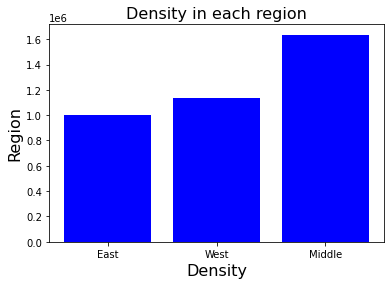

In [44]:
# Visualize region population

plt.bar('Region', 'Population', data=tn_region, color='blue')
plt.xlabel("Population", fontsize = 16)
plt.ylabel("Region", fontsize = 16)
plt.title("Population in each region", fontsize = 16)


Text(0.5, 1.0, 'Density in each region')

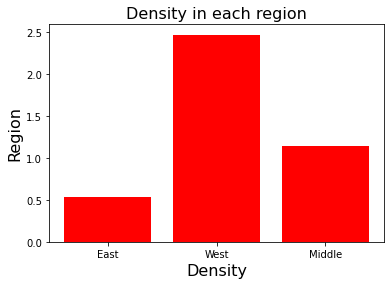

In [45]:
# Visualize population density
tn_region['Density'] = tn['Population']/tn_region['Area (sqmi)']
plt.bar('Region', 'Density', data=tn_region, color='red')
plt.xlabel("Density", fontsize = 16)
plt.ylabel("Region", fontsize = 16)
plt.title("Density in each region", fontsize = 16)

### As a potential restaraunt owner, one can safely choose West TN.

#### Now let's narrow down to city

Text(0.5, 1.0, 'Top 5 city by population')

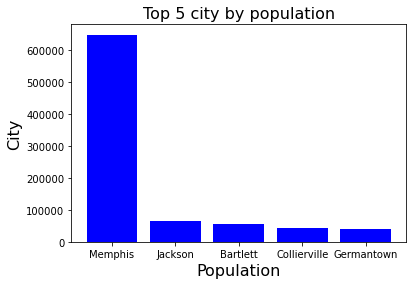

In [63]:
# Find top 5 city by population

tn_regionw = tn.loc[lambda row:row['Region'] == 'West'].sort_values('Population', ascending=False).head(5)
plt.bar('City', 'Population', data=tn_regionw, color='blue')
plt.xlabel("Population", fontsize = 16)
plt.ylabel("City", fontsize = 16)
plt.title("Top 5 city by population", fontsize = 16)


Text(0.5, 1.0, 'Top 5 city by population density')

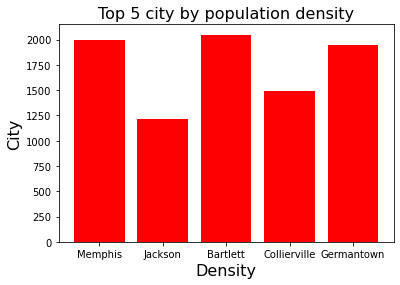

In [66]:
# Find top 5 city by population density

tn_regionw['Density'] = tn_regionw['Population']/tn_regionw['Area (sqmi)']
plt.bar('City', 'Density', data=tn_regionw, color='Red')
plt.xlabel("Density", fontsize = 16)
plt.ylabel("City", fontsize = 16)
plt.title("Top 5 city by population density", fontsize = 16)


# As Memphis is one of the top 5 cities by population and by population density. Let's go Memphis